In [ ]:
import cv2
import numpy as np

# =========================================================
# Configuration Classes
# =========================================================

class _ProjectionConfig:
    def __init__(self, R=1.0, phi1_deg=0.0, lam0_deg=0.0,
                 lon_points=1024, lat_points=512, lon_min=-180.0, lon_max=180.0,
                 lat_min=-90.0, lat_max=90.0, x_points=512, y_points=512,
                 x_min=-1.0, x_max=1.0, y_min=-1.0, y_max=1.0):
        self.R = R
        self.phi1_deg = phi1_deg
        self.lam0_deg = lam0_deg
        self.lon_points = lon_points
        self.lat_points = lat_points
        self.lon_min = lon_min
        self.lon_max = lon_max
        self.lat_min = lat_min
        self.lat_max = lat_max
        self.x_points = x_points
        self.y_points = y_points
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max

class ProjectionConfig:
    def __init__(self, R=1.0, phi1_deg=0.0, lam0_deg=0.0,
                 lon_points=1024, lat_points=512, lon_min=-180.0, lon_max=180.0,
                 lat_min=-90.0, lat_max=90.0, x_points=512, y_points=512,
                 x_min=-1.0, x_max=1.0, y_min=-1.0, y_max=1.0, fov_deg=90.0):
        self.R = R
        self.phi1_deg = phi1_deg
        self.lam0_deg = lam0_deg
        self.lon_points = lon_points
        self.lat_points = lat_points
        self.lon_min = lon_min
        self.lon_max = lon_max
        self.lat_min = lat_min
        self.lat_max = lat_max
        self.x_points = x_points
        self.y_points = y_points
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.fov_deg = fov_deg
        
class InterpolationConfig:
    def __init__(self, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0):
        self.interpolation = interpolation
        self.borderMode = borderMode
        self.borderValue = borderValue


# =========================================================
# Gnomonic Projection Functions
# =========================================================

def gnomonic_backward(R, phi1_deg, lam0_deg, phi_deg, lam_deg):
    phi1, lam0, phi, lam = map(np.deg2rad, [phi1_deg, lam0_deg, phi_deg, lam_deg])
    cos_c = np.sin(phi1) * np.sin(phi) + np.cos(phi1) * np.cos(phi) * np.cos(lam - lam0)
    x = R * np.cos(phi) * np.sin(lam - lam0) / cos_c
    y = R * (np.cos(phi1) * np.sin(phi) - np.sin(phi1) * np.cos(phi) * np.cos(lam - lam0)) / cos_c
    return x, y , cos_c > 0


def gnomonic_inverse(R, phi1_deg, lam0_deg, x, y):
    phi1, lam0 = map(np.deg2rad, [phi1_deg, lam0_deg])
    rho = np.sqrt(x**2 + y**2)
    c = np.arctan2(rho, R)
    sin_c, cos_c = np.sin(c), np.cos(c)
    phi = np.arcsin(cos_c * np.sin(phi1) + (y * sin_c * np.cos(phi1)) / rho)
    lam = lam0 + np.arctan2(x * sin_c, rho * np.cos(phi1) * cos_c - y * np.sin(phi1) * sin_c)
    return np.rad2deg(phi), np.rad2deg(lam)

#def gnomonic_forward(R, phi1_deg, lam0_deg, phi_deg, lam_deg):
#    phi1, lam0, phi, lam = map(np.deg2rad, [phi1_deg, lam0_deg, phi_deg, lam_deg])
#    cos_c = np.sin(phi1) * np.sin(phi) + np.cos(phi1) * np.cos(phi) * np.cos(lam - lam0)
#    x = R * np.cos(phi) * np.sin(lam - lam0) / cos_c
#    y = -R * (np.cos(phi1) * np.sin(phi) - np.sin(phi1) * np.cos(phi) * np.cos(lam - lam0)) / cos_c
#    return x, y, cos_c > 0


def gnomonic_forward(R, phi1_deg, lam0_deg, x, y):
    phi1, lam0 = map(np.deg2rad, [phi1_deg, lam0_deg])
    rho = np.sqrt(x**2 + y**2)
    c = np.arctan2(rho, R)
    sin_c, cos_c = np.sin(c), np.cos(c)
    phi = np.arcsin(cos_c * np.sin(phi1) - (y * sin_c * np.cos(phi1)) / rho)
    lam = lam0 + np.arctan2(x * sin_c, rho * np.cos(phi1) * cos_c + y * np.sin(phi1) * sin_c)
    return np.rad2deg(phi), np.rad2deg(lam)
    
# =========================================================
# Forward Steps
# =========================================================

def create_backward_grid(config: ProjectionConfig):
    """
    Create a grid of latitude and longitude values.
    """
    lon_vals = np.linspace(config.lon_min, config.lon_max, config.lon_points)
    lat_vals = np.linspace(config.lat_min, config.lat_max, config.lat_points)
    return np.meshgrid(lon_vals, lat_vals)


def backward_projection(config: ProjectionConfig, lat, lon):
    """
    Forward project latitude and longitude to (x, y) using Gnomonic.
    """
    return gnomonic_backward(config.R, config.phi1_deg, config.lam0_deg, lat, lon)


def backward_to_image_coordinates(config: ProjectionConfig, x, y):
    """
    Convert (x, y) in Gnomonic space to pixel coordinates in the output grid.
    """
    x_min, x_max, y_min, y_max = config.x_min, config.x_max, config.y_min, config.y_max
    w, h = config.x_points, config.y_points
    map_x = (x - x_min) / (x_max - x_min) * (w - 1)
    #map_y = (y - y_min) / (y_max - y_min) * (h - 1)
    map_y = (y_max - y) / (y_max - y_min) * (h - 1)
    return map_x, map_y

def backward_to_image_coordinates(config: ProjectionConfig, x, y):
    """
    Convert (x, y) in Gnomonic space to pixel coordinates in the output grid, considering FOV.
    """
    x_min, x_max, y_min, y_max = config.x_min, config.x_max, config.y_min, config.y_max
    w, h = config.x_points, config.y_points
    map_x = (x - x_min) / (x_max - x_min) * (w - 1)
    map_y = (y_max - y) / (y_max - y_min) * (h - 1)
    return map_x, map_y
    
def interpolate_backward(config: InterpolationConfig, input_img, map_x, map_y, mask):
    """
    Use cv2.remap to interpolate the equirectangular image based on (map_x, map_y).
    """
    map_x_32 = map_x.astype(np.float32)
    map_y_32 = map_y.astype(np.float32)
    output = cv2.remap(input_img, map_x_32, map_y_32, interpolation=config.interpolation,
                     borderMode=config.borderMode, borderValue=config.borderValue)
    return cv2.flip(output * mask[:,:,None], 0)


# =========================================================
# Forward Steps
# =========================================================

def create_forward_grid(config: ProjectionConfig):
    """
    Create a grid of (x, y) in Gnomonic space.
    """
    x_vals = np.linspace(config.x_min, config.x_max, config.x_points)
    y_vals = np.linspace(config.y_min, config.y_max, config.y_points)
    return np.meshgrid(x_vals, y_vals)

def create_forward_grid(config: ProjectionConfig):
    """
    Create a grid of (x, y) in Gnomonic space, scaled by FOV.
    """
    fov_rad = np.deg2rad(config.fov_deg)
    half_size = np.tan(fov_rad / 2) * config.R
    config.x_min, config.x_max = -half_size, half_size
    config.y_min, config.y_max = -half_size, half_size
    
    x_vals = np.linspace(config.x_min, config.x_max, config.x_points)
    y_vals = np.linspace(config.y_min, config.y_max, config.y_points)
    return np.meshgrid(x_vals, y_vals)

def forward_projection(config: ProjectionConfig, x, y):
    """
    Inverse project (x, y) to latitude and longitude using Gnomonic.
    """
    return gnomonic_forward(config.R, config.phi1_deg, config.lam0_deg, x, y)


def forward_to_image_coordinates(config: ProjectionConfig, lat, lon, H, W):
    """
    Convert latitude and longitude to pixel coordinates in the input grid.
    """
    lon[lon>180] = -(lon[lon>180] - 180)
    print(lon.max(),lon.min(),lat.max(),lat.min())
    
    map_x = (lon - config.lon_min) / (config.lon_max - config.lon_min) * (W - 1)
    #map_y = (lat - config.lat_min) / (config.lat_max - config.lat_min) * (H - 1)
    map_y = (config.lat_max - lat) / (config.lat_max - config.lat_min) * (H - 1)
    return map_x, map_y


def interpolate_forward(config: InterpolationConfig, gnomonic_img, map_x, map_y):
    """
    Use cv2.remap to interpolate the gnomonic image based on (map_x, map_y).
    """
    map_x_32 = map_x.astype(np.float32)
    map_y_32 = map_y.astype(np.float32)
    
    return cv2.remap(gnomonic_img, map_x_32, map_y_32, interpolation=config.interpolation,
                     borderMode=config.borderMode, borderValue=config.borderValue)


# =========================================================
# Example Usage
# =========================================================

# Load input image
equirect_img = cv2.imread("data/image1.png")
if equirect_img is None:
    raise RuntimeError("Failed to load image.")
H, W = equirect_img.shape[:2]

# Configurations
proj_config = ProjectionConfig(phi1_deg=30,
                               lam0_deg=0,
                               lat_min=-90,
                               fov_deg=60
                              )


bm = cv2.BORDER_CONSTANT
#bm = cv2.BORDER_REFLECT
#bm = cv2.BORDER_REFLECT_101
#bm = cv2.BORDER_REPLICATE
#bm = cv2.BORDER_WRAP

interp_config = InterpolationConfig(
    borderMode=bm
)

# to rectilinear
# Forward
x_grid, y_grid = create_forward_grid(proj_config)
lat, lon = forward_projection(proj_config, x_grid, y_grid)
map_x, map_y = forward_to_image_coordinates(proj_config, lat, lon, H, W)
rectilinear_img = interpolate_forward(interp_config, equirect_img, map_x, map_y)
cv2.imwrite("equirect_back.png", rectilinear_img)

# to equirectangular
# Backward transformation
lon_grid, lat_grid = create_backward_grid(proj_config)
x, y , mask = backward_projection(proj_config, lat_grid, lon_grid)
map_x, map_y = backward_to_image_coordinates(proj_config, x, y)
equirectangular_img = interpolate_backward(interp_config, rectilinear_img, map_x, map_y, mask)
cv2.imwrite("equirectangular_out.png", equirectangular_img )

print("Images saved successfully.")


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(equirect_img )
plt.show()
plt.imshow(rectilinear_img)
plt.show()
plt.imshow(equirectangular_img)

In [ ]:
import cv2
import numpy as np

# =========================================================
# Configuration Classes
# =========================================================

class ProjectionConfig:
    def __init__(self, R=1.0, phi1_deg=0.0, lam0_deg=0.0,
                 lon_points=1024, lat_points=512, lon_min=-180.0, lon_max=180.0,
                 lat_min=-90.0, lat_max=90.0, x_points=512, y_points=512,
                 x_min=-1.0, x_max=1.0, y_min=-1.0, y_max=1.0, fov_deg=90.0):
        self.R = R
        self.phi1_deg = phi1_deg
        self.lam0_deg = lam0_deg
        self.lon_points = lon_points
        self.lat_points = lat_points
        self.lon_min = lon_min
        self.lon_max = lon_max
        self.lat_min = lat_min
        self.lat_max = lat_max
        self.x_points = x_points
        self.y_points = y_points
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.fov_deg = fov_deg
        
class InterpolationConfig:
    def __init__(self, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0):
        self.interpolation = interpolation
        self.borderMode = borderMode
        self.borderValue = borderValue


# =========================================================
# Abstract Base Projection Class
# =========================================================

class BaseProjection:
    def __init__(self, config: ProjectionConfig):
        self.config = config

    def forward(self, x, y):
        raise NotImplementedError("Forward projection must be implemented by subclasses.")

    def backward(self, lat, lon):
        raise NotImplementedError("Backward projection must be implemented by subclasses.")

    def create_grid(self, direction='forward'):
        if direction == 'forward':
            x_vals = np.linspace(self.config.x_min, self.config.x_max, self.config.x_points)
            y_vals = np.linspace(self.config.y_min, self.config.y_max, self.config.y_points)
            return np.meshgrid(x_vals, y_vals)
        elif direction == 'backward':
            lon_vals = np.linspace(self.config.lon_min, self.config.lon_max, self.config.lon_points)
            lat_vals = np.linspace(self.config.lat_min, self.config.lat_max, self.config.lat_points)
            return np.meshgrid(lon_vals, lat_vals)
        else:
            raise ValueError("Direction must be 'forward' or 'backward'.")

# =========================================================
# Gnomonic Projection Implementation
# =========================================================

class GnomonicProjection(BaseProjection):
    def forward(self, x, y):
        phi1, lam0 = map(np.deg2rad, [self.config.phi1_deg, self.config.lam0_deg])
        rho = np.sqrt(x**2 + y**2)
        c = np.arctan2(rho, self.config.R)
        sin_c, cos_c = np.sin(c), np.cos(c)
        phi = np.arcsin(cos_c * np.sin(phi1) - (y * sin_c * np.cos(phi1)) / rho)
        lam = lam0 + np.arctan2(x * sin_c, rho * np.cos(phi1) * cos_c + y * np.sin(phi1) * sin_c)
        return np.rad2deg(phi), np.rad2deg(lam)

    def backward(self, lat, lon):
        phi1, lam0 = map(np.deg2rad, [self.config.phi1_deg, self.config.lam0_deg])
        phi, lam = map(np.deg2rad, [lat, lon])
        cos_c = np.sin(phi1) * np.sin(phi) + np.cos(phi1) * np.cos(phi) * np.cos(lam - lam0)
        x = self.config.R * np.cos(phi) * np.sin(lam - lam0) / cos_c
        y = self.config.R * (np.cos(phi1) * np.sin(phi) - np.sin(phi1) * np.cos(phi) * np.cos(lam - lam0)) / cos_c
        return x, y, cos_c > 0


# =========================================================
# Projection Processor
# =========================================================

class ProjectionProcessor:
    def __init__(self, projection: BaseProjection, interpolation_config: InterpolationConfig):
        self.projection = projection
        self.interp_config = interpolation_config

    def forward_projection(self, input_img):
        x_grid, y_grid = self.projection.create_grid('forward')
        lat, lon = self.projection.forward(x_grid, y_grid)
        map_x, map_y = self._latlon_to_image_coords(lat, lon, input_img.shape)
        return self._interpolate(input_img, map_x, map_y)

    def backward_projection(self, input_img):
        lon_grid, lat_grid = self.projection.create_grid('backward')
        x, y, mask = self.projection.backward(lat_grid, lon_grid)
        map_x, map_y = self._xy_to_image_coords(x, y)
        return cv2.flip(self._interpolate(input_img, map_x, map_y, mask),0)

    def _latlon_to_image_coords(self, lat, lon, shape):
        H, W = shape[:2]
        lon[lon > 180] = -(lon[lon > 180] - 180)
        map_x = (lon - self.projection.config.lon_min) / (self.projection.config.lon_max - self.projection.config.lon_min) * (W - 1)
        map_y = (self.projection.config.lat_max - lat) / (self.projection.config.lat_max - self.projection.config.lat_min) * (H - 1)
        return map_x, map_y

    def _xy_to_image_coords(self, x, y):
        config = self.projection.config
        w, h = config.x_points, config.y_points
        map_x = (x - config.x_min) / (config.x_max - config.x_min) * (w - 1)
        map_y = (config.y_max - y) / (config.y_max - config.y_min) * (h - 1)
        return map_x, map_y

    def _interpolate(self, input_img, map_x, map_y, mask=None):
        map_x_32 = map_x.astype(np.float32)
        map_y_32 = map_y.astype(np.float32)
        result = cv2.remap(input_img, map_x_32, map_y_32,
                           interpolation=self.interp_config.interpolation,
                           borderMode=self.interp_config.borderMode,
                           borderValue=self.interp_config.borderValue)
        if mask is not None:
            result *= mask[:, :, None]
        return result

# =========================================================
# Example Usage
# =========================================================

#if __name__ == "__main__":
equirect_img = cv2.imread("data/image1.png")
if equirect_img is None:
    raise RuntimeError("Failed to load image.")

proj_config = ProjectionConfig(phi1_deg=0, lam0_deg=0, fov_deg=60)
interp_config = InterpolationConfig(borderMode=cv2.BORDER_CONSTANT)
gnomonic_proj = GnomonicProjection(proj_config)

processor = ProjectionProcessor(gnomonic_proj, interp_config)
rectilinear_img = processor.forward_projection(equirect_img)
cv2.imwrite("rectilinear.png", rectilinear_img)

equirectangular_img = processor.backward_projection(rectilinear_img)
cv2.imwrite("equirectangular.png", equirectangular_img)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(equirect_img )
plt.show()
plt.imshow(rectilinear_img)
plt.show()
plt.imshow(equirectangular_img)
plt.show()

In [ ]:
import cv2
import numpy as np


# =========================================================
# Projection Config and Strategy
# =========================================================
class BaseProjectionConfig:
    def create_projection(self):
        raise NotImplementedError("Subclasses must implement create_projection.")


class GnomonicProjectionConfig(BaseProjectionConfig):
    def __init__(self, R=1.0, phi1_deg=0.0, lam0_deg=0.0, fov_deg=90.0):
        self.R = R
        self.phi1_deg = phi1_deg
        self.lam0_deg = lam0_deg
        self.fov_deg = fov_deg

    def create_projection(self):
        return GnomonicProjectionStrategy(self)


class BaseProjectionStrategy:
    def forward(self, x, y):
        raise NotImplementedError("Subclasses must implement forward.")

    def backward(self, lat, lon):
        raise NotImplementedError("Subclasses must implement backward.")


class GnomonicProjectionStrategy(BaseProjectionStrategy):
    def __init__(self, config: GnomonicProjectionConfig):
        self.config = config

    def forward(self, x, y):
        phi1, lam0 = map(np.deg2rad, [self.config.phi1_deg, self.config.lam0_deg])
        rho = np.sqrt(x**2 + y**2)
        c = np.arctan2(rho, self.config.R)
        sin_c, cos_c = np.sin(c), np.cos(c)
        phi = np.arcsin(cos_c * np.sin(phi1) - (y * sin_c * np.cos(phi1)) / rho)
        lam = lam0 + np.arctan2(x * sin_c, rho * np.cos(phi1) * cos_c + y * np.sin(phi1) * sin_c)
        return np.rad2deg(phi), np.rad2deg(lam)

    def backward(self, lat, lon):
        phi1, lam0 = map(np.deg2rad, [self.config.phi1_deg, self.config.lam0_deg])
        phi, lam = map(np.deg2rad, [lat, lon])
        cos_c = np.sin(phi1) * np.sin(phi) + np.cos(phi1) * np.cos(phi) * np.cos(lam - lam0)
        x = self.config.R * np.cos(phi) * np.sin(lam - lam0) / cos_c
        y = self.config.R * (np.cos(phi1) * np.sin(phi) - np.sin(phi1) * np.cos(phi) * np.cos(lam - lam0)) / cos_c
        return x, y, cos_c > 0


# =========================================================
# Grid Generation Config and Strategy
# =========================================================

class BaseGridGenerationConfig:
    def create_grid_generation(self):
        raise NotImplementedError("Subclasses must implement create_grid_generation.")


class GnomonicGridGenerationConfig(BaseGridGenerationConfig):
    def __init__(self, x_points=512, y_points=512, lon_points=1024, lat_points=512,
                 x_min=-1.0, x_max=1.0, y_min=-1.0, y_max=1.0,
                 lon_min=-180.0, lon_max=180.0, lat_min=-90.0, lat_max=90.0):
        self.x_points = x_points
        self.y_points = y_points
        self.lon_points = lon_points
        self.lat_points = lat_points
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.lon_min = lon_min
        self.lon_max = lon_max
        self.lat_min = lat_min
        self.lat_max = lat_max

    def create_grid_generation(self):
        return GnomonicGridGeneration(self)


class BaseGridGeneration:
    def create_grid(self, direction):
        raise NotImplementedError("Subclasses must implement create_grid.")


class GnomonicGridGeneration(BaseGridGeneration):
    def __init__(self, config: GnomonicGridGenerationConfig):
        self.config = config

    def create_grid(self, direction):
        if direction == 'forward':
            x_vals = np.linspace(self.config.x_min, self.config.x_max, self.config.x_points)
            y_vals = np.linspace(self.config.y_min, self.config.y_max, self.config.y_points)
            return np.meshgrid(x_vals, y_vals)
        elif direction == 'backward':
            lon_vals = np.linspace(self.config.lon_min, self.config.lon_max, self.config.lon_points)
            lat_vals = np.linspace(self.config.lat_min, self.config.lat_max, self.config.lat_points)
            return np.meshgrid(lon_vals, lat_vals)
        else:
            raise ValueError("Direction must be 'forward' or 'backward'.")


# =========================================================
# Interpolation Config and Strategy
# =========================================================

class BaseInterpolationConfig:
    def create_interpolation(self):
        raise NotImplementedError("Subclasses must implement create_interpolation.")



class InterpolationConfig(BaseInterpolationConfig):
    def __init__(self, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0):
        self.interpolation = interpolation
        self.borderMode = borderMode
        self.borderValue = borderValue

    def create_interpolation(self):
        return BaseInterpolation(self)


class BaseInterpolation:
    def __init__(self, config: InterpolationConfig):
        self.config = config

    def interpolate(self, input_img, map_x, map_y, mask=None):
        map_x_32 = map_x.astype(np.float32)
        map_y_32 = map_y.astype(np.float32)
        result = cv2.remap(input_img, map_x_32, map_y_32,
                           interpolation=self.config.interpolation,
                           borderMode=self.config.borderMode,
                           borderValue=self.config.borderValue)
        if mask is not None:
            result *= mask[:, :, None]
        return result


# =========================================================
# Coordinate Transformer
# =========================================================

class CoordinateTransformer:
    @staticmethod
    def latlon_to_image_coords(lat, lon, config, shape):
        H, W = shape[:2]
        map_x = (lon - config.lon_min) / (config.lon_max - config.lon_min) * (W - 1)
        map_y = (config.lat_max - lat) / (config.lat_max - config.lat_min) * (H - 1)
        return map_x, map_y

    @staticmethod
    def xy_to_image_coords(x, y, config):
        map_x = (x - config.x_min) / (config.x_max - config.x_min) * (config.x_points - 1)
        map_y = (config.y_max - y) / (config.y_max - config.y_min) * (config.y_points - 1)
        return map_x, map_y


# =========================================================
# Projection Processor
# =========================================================

class ProjectionProcessor:
    def __init__(self, projection_cfg=None, projection_cls=None,
                 gridgeneration_cfg=None, gridgeneration_cls=None,
                 interpolation_cfg=None, interpolation_cls=None):
        self.projection = projection_cfg.create_projection() if projection_cfg else projection_cls
        self.grid_generation = gridgeneration_cfg.create_grid_generation() if gridgeneration_cfg else gridgeneration_cls
        self.interpolation = interpolation_cfg.create_interpolation() if interpolation_cfg else interpolation_cls

    def forward_projection(self, input_img):
        x_grid, y_grid = self.grid_generation.create_grid('forward')
        lat, lon = self.projection.forward(x_grid, y_grid)
        map_x, map_y = CoordinateTransformer.latlon_to_image_coords(lat, lon, self.grid_generation.config, input_img.shape)
        return self.interpolation.interpolate(input_img, map_x, map_y)

    def backward_projection(self, input_img):
        lon_grid, lat_grid = self.grid_generation.create_grid('backward')
        x, y, mask = self.projection.backward(lat_grid, lon_grid)
        map_x, map_y = CoordinateTransformer.xy_to_image_coords(x, y, self.grid_generation.config)
        return cv2.flip(self.interpolation.interpolate(input_img, map_x, map_y, mask),0)


# =========================================================
# Example Usage
# =========================================================



In [ ]:
#if __name__ == "__main__":
equirect_img = cv2.imread("data/image1.png")
if equirect_img is None:
    raise RuntimeError("Failed to load image.")

proj_cfg = GnomonicProjectionConfig(phi1_deg=0, lam0_deg=0)
grid_cfg = GnomonicGridGenerationConfig()
interp_cfg = InterpolationConfig()

processor = ProjectionProcessor(projection_cfg=proj_cfg,
                                 gridgeneration_cfg=grid_cfg,
                                 interpolation_cfg=interp_cfg)

rectilinear_img = processor.forward_projection(equirect_img)
cv2.imwrite("rectilinear.png", rectilinear_img)

equirectangular_img = processor.backward_projection(rectilinear_img)
cv2.imwrite("equirectangular.png", equirectangular_img)

In [ ]:
import cv2
import numpy as np


# =========================================================
# Unified Configuration Classes
# =========================================================

class BaseProjectionConfig:
    def create_projection(self):
        raise NotImplementedError("Subclasses must implement create_projection.")

    def create_grid_generation(self):
        raise NotImplementedError("Subclasses must implement create_grid_generation.")

    def create_interpolation(self):
        raise NotImplementedError("Subclasses must implement create_interpolation.")

    def update(self, **kwargs):
        """
        Update configuration parameters dynamically.

        Args:
            **kwargs: Parameters to update in the configuration.
        """
        for key, value in kwargs.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                self.extra_params[key] = value

class GnomonicConfig(BaseProjectionConfig):
    def __init__(self, **kwargs):
        # Default parameters
        self.R = kwargs.get('R', 1.0)
        self.phi1_deg = kwargs.get('phi1_deg', 0.0)
        self.lam0_deg = kwargs.get('lam0_deg', 0.0)
        self.fov_deg = kwargs.get('fov_deg', 90.0)

        # Grid generation parameters
        self.x_points = kwargs.get('x_points', 512)
        self.y_points = kwargs.get('y_points', 512)
        self.lon_points = kwargs.get('lon_points', 1024)
        self.lat_points = kwargs.get('lat_points', 512)
        self.x_min = kwargs.get('x_min', -1.0)
        self.x_max = kwargs.get('x_max', 1.0)
        self.y_min = kwargs.get('y_min', -1.0)
        self.y_max = kwargs.get('y_max', 1.0)
        self.lon_min = kwargs.get('lon_min', -180.0)
        self.lon_max = kwargs.get('lon_max', 180.0)
        self.lat_min = kwargs.get('lat_min', -90.0)
        self.lat_max = kwargs.get('lat_max', 90.0)

        # Interpolation parameters
        self.interpolation = kwargs.get('interpolation', cv2.INTER_LINEAR)
        self.borderMode = kwargs.get('borderMode', cv2.BORDER_CONSTANT)
        self.borderValue = kwargs.get('borderValue', 0)

        # Store additional parameters for extensibility
        self.extra_params = {k: v for k, v in kwargs.items() if k not in self.__dict__}



    def create_projection(self):
        return GnomonicProjectionStrategy(self)

    def create_grid_generation(self):
        return GnomonicGridGeneration(self)

    def create_interpolation(self):
        return BaseInterpolation(self)

    def __repr__(self):
        return (
            f"GnomonicConfig(R={self.R}, phi1_deg={self.phi1_deg}, lam0_deg={self.lam0_deg}, "
            f"fov_deg={self.fov_deg}, x_points={self.x_points}, y_points={self.y_points}, "
            f"lon_points={self.lon_points}, lat_points={self.lat_points}, "
            f"x_min={self.x_min}, x_max={self.x_max}, y_min={self.y_min}, y_max={self.y_max}, "
            f"lon_min={self.lon_min}, lon_max={self.lon_max}, lat_min={self.lat_min}, lat_max={self.lat_max}, "
            f"interpolation={self.interpolation}, borderMode={self.borderMode}, borderValue={self.borderValue}, "
            f"extra_params={self.extra_params})"
        )

# =========================================================
# Projection Strategy
# =========================================================

class BaseProjectionStrategy:
    def forward(self, x, y):
        raise NotImplementedError("Subclasses must implement forward.")

    def backward(self, lat, lon):
        raise NotImplementedError("Subclasses must implement backward.")


class GnomonicProjectionStrategy(BaseProjectionStrategy):
    def __init__(self, config: GnomonicConfig):
        self.config = config

    def forward(self, x, y):
        phi1, lam0 = map(np.deg2rad, [self.config.phi1_deg, self.config.lam0_deg])
        rho = np.sqrt(x**2 + y**2)
        c = np.arctan2(rho, self.config.R)
        sin_c, cos_c = np.sin(c), np.cos(c)
        phi = np.arcsin(cos_c * np.sin(phi1) - (y * sin_c * np.cos(phi1)) / rho)
        lam = lam0 + np.arctan2(x * sin_c, rho * np.cos(phi1) * cos_c + y * np.sin(phi1) * sin_c)
        return np.rad2deg(phi), np.rad2deg(lam)

    def backward(self, lat, lon):
        phi1, lam0 = map(np.deg2rad, [self.config.phi1_deg, self.config.lam0_deg])
        phi, lam = map(np.deg2rad, [lat, lon])
        cos_c = np.sin(phi1) * np.sin(phi) + np.cos(phi1) * np.cos(phi) * np.cos(lam - lam0)
        x = self.config.R * np.cos(phi) * np.sin(lam - lam0) / cos_c
        y = self.config.R * (np.cos(phi1) * np.sin(phi) - np.sin(phi1) * np.cos(phi) * np.cos(lam - lam0)) / cos_c
        return x, y, cos_c > 0


# =========================================================
# Grid Generation
# =========================================================

class BaseGridGeneration:
    def create_grid(self, direction):
        raise NotImplementedError("Subclasses must implement create_grid.")


class GnomonicGridGeneration(BaseGridGeneration):
    def __init__(self, config: GnomonicConfig):
        self.config = config

    def create_grid(self, direction):
        if direction == 'forward':
            x_vals = np.linspace(self.config.x_min, self.config.x_max, self.config.x_points)
            y_vals = np.linspace(self.config.y_min, self.config.y_max, self.config.y_points)
            return np.meshgrid(x_vals, y_vals)
        elif direction == 'backward':
            lon_vals = np.linspace(self.config.lon_min, self.config.lon_max, self.config.lon_points)
            lat_vals = np.linspace(self.config.lat_min, self.config.lat_max, self.config.lat_points)
            return np.meshgrid(lon_vals, lat_vals)
        else:
            raise ValueError("Direction must be 'forward' or 'backward'.")


# =========================================================
# Interpolation
# =========================================================

class BaseInterpolation:
    def __init__(self, config: GnomonicConfig):
        self.config = config

    def interpolate(self, input_img, map_x, map_y, mask=None):
        map_x_32 = map_x.astype(np.float32)
        map_y_32 = map_y.astype(np.float32)
        result = cv2.remap(input_img, map_x_32, map_y_32,
                           interpolation=self.config.interpolation,
                           borderMode=self.config.borderMode,
                           borderValue=self.config.borderValue)
        if mask is not None:
            result *= mask[:, :, None]
        return result


# =========================================================
# Coordinate Transformer
# =========================================================

class CoordinateTransformer:
    @staticmethod
    def latlon_to_image_coords(lat, lon, config, shape):
        H, W = shape[:2]
        map_x = (lon - config.lon_min) / (config.lon_max - config.lon_min) * (W - 1)
        map_y = (config.lat_max - lat) / (config.lat_max - config.lat_min) * (H - 1)
        return map_x, map_y

    @staticmethod
    def xy_to_image_coords(x, y, config):
        map_x = (x - config.x_min) / (config.x_max - config.x_min) * (config.x_points - 1)
        map_y = (config.y_max - y) / (config.y_max - config.y_min) * (config.y_points - 1)
        return map_x, map_y


# =========================================================
# Projection Processor
# =========================================================
class ProjectionProcessor:
    def __init__(self, config: BaseProjectionConfig):
        self.config = config
        self.projection = config.create_projection()
        self.grid_generation = config.create_grid_generation()
        self.interpolation = config.create_interpolation()

    def forward(self, img: np.ndarray, **kwargs) -> np.ndarray:
        """
        Forward projection of an image.

        Args:
            img (np.ndarray): The input equirectangular image.
            **kwargs: Additional parameters to override projection configuration.

        Returns:
            np.ndarray: Projected rectilinear image.
        """
        # Update configuration with dynamic parameters
        self.config.update(**kwargs)

        # Generate grid
        x_grid, y_grid = self.grid_generation.create_grid('forward')

        # Forward projection
        lat, lon = self.projection.forward(x_grid, y_grid)

        # Transform lat/lon to image coordinates
        map_x, map_y = CoordinateTransformer.latlon_to_image_coords(lat, lon, self.grid_generation.config, img.shape)

        # Interpolate to get the rectilinear image
        return self.interpolation.interpolate(img, map_x, map_y)

    def backward(self, rect_img: np.ndarray, img_shape: tuple, **kwargs) -> np.ndarray:
        """
        Backward projection of a rectilinear image to equirectangular.

        Args:
            rect_img (np.ndarray): The rectilinear image.
            img_shape (tuple): Shape of the equirectangular image (height, width).
            **kwargs: Additional parameters to override projection configuration.

        Returns:
            np.ndarray: Back-projected equirectangular image.
        """
        # Update configuration with dynamic parameters
        self.config.update(**kwargs)

        # Generate grid
        lon_grid, lat_grid = self.grid_generation.create_grid('backward')

        # Backward projection
        x, y, mask = self.projection.backward(lat_grid, lon_grid)

        # Transform (x, y) to image coordinates
        map_x, map_y = CoordinateTransformer.xy_to_image_coords(x, y, self.grid_generation.config)

        # Interpolate to get the equirectangular image
        back_projected_img = self.interpolation.interpolate(rect_img, map_x, map_y, mask if kwargs.get("return_mask", False) else None)

        return cv2.flip(back_projected_img * mask[:,:,None],0) 


In [ ]:
# =========================================================
# Example Usage
# =========================================================

#if __name__ == "__main__":
equirect_img = cv2.imread("data/image1.png")
if equirect_img is None:
    raise RuntimeError("Failed to load image.")

config = GnomonicConfig(phi1_deg=0, lam0_deg=0, fov_deg=60)
processor = ProjectionProcessor(config)

rectilinear_img = processor.forward(equirect_img, phi1_deg=40, lam0_deg=0, fov_deg=(60,60))
cv2.imwrite("rectilinear.png", rectilinear_img)

equirectangular_img = processor.backward(rectilinear_img,img_shape=equirect_img.shape,phi1_deg=0, lam0_deg=0, fov_deg=(60,60))
cv2.imwrite("equirectangular.png", equirectangular_img)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(equirect_img )
plt.show()
plt.imshow(rectilinear_img)
plt.show()
plt.imshow(equirectangular_img)

In [ ]:
import projection 

In [ ]:
print(projection.ProjectionRegistry.list_projections())

In [ ]:
from projection.default_projections import register_default_projections
from projection.registry import ProjectionRegistry

# Register all default projections
register_default_projections()

# List available projections
print(ProjectionRegistry.list_projections())  # Output: ['gnomonic']

In [ ]:
# Retrieve and instantiate a Gnomonic projection
projection_config = projection.ProjectionRegistry.get_projection("gnomonic", R=2.0, phi1_deg=45.0)

# Access parameters and objects
print(projection_config.R)  # Output: 2.0
print(projection_config.phi1_deg)  # Output: 45.0

# Create and use the projection components
projection = projection_config.create_projection()
grid = projection_config.create_grid_generation()
interpolation = projection_config.create_interpolation()

print(projection_config)  # Output: Human-readable configuration details

In [ ]:
import cv2
from projection.registry import ProjectionRegistry
from projection.processor import ProjectionProcessor

# Step 1: Load the equirectangular image
equirect_img = cv2.imread("data/image1.png")
if equirect_img is None:
    raise RuntimeError("Failed to load the image.")

# Step 2: Retrieve and instantiate a Gnomonic projection config 
config = ProjectionRegistry.get_projection("gnomonic")
config.update(phi1_deg=0, lam0_deg=0, fov_deg=90)

# Step 3: Initialize the processor
processor = ProjectionProcessor(config)

# Step 4: Perform forward projection to rectilinear
rectilinear_img = processor.forward(equirect_img, phi1_deg=0, lam0_deg=0, fov_deg=(60, 60))
cv2.imwrite("rectilinear.png", rectilinear_img)

# Step 5: Perform backward projection to equirectangular
equirectangular_img = processor.backward(
    rectilinear_img,
    img_shape=equirect_img.shape,
    phi1_deg=0,
    lam0_deg=0,
    fov_deg=(60, 60),
)
cv2.imwrite("equirectangular.png", equirectangular_img)

In [4]:
import cv2
from projection.registry import ProjectionRegistry
from projection.processor import ProjectionProcessor

# Step 1: Load the equirectangular image
equirect_img = cv2.imread("data/image1.png")
if equirect_img is None:
    raise RuntimeError("Failed to load the image.")

# Step 2: Retrieve and instantiate a Gnomonic projection config 
processor = ProjectionRegistry.get_projection("gnomonic", return_processor=True,  phi1_deg=0, lam0_deg=0, fov_deg=90)

# Step 4: Perform forward projection to rectilinear
rectilinear_img = processor.forward(equirect_img, phi1_deg=0, lam0_deg=0, fov_deg=(60, 60))
cv2.imwrite("rectilinear.png", rectilinear_img)

# Step 5: Perform backward projection to equirectangular
equirectangular_img = processor.backward(
    rectilinear_img,
    img_shape=equirect_img.shape,
    phi1_deg=0,
    lam0_deg=0,
    fov_deg=(60, 60),
    return_mask=True,
)
cv2.imwrite("equirectangular.png", equirectangular_img)

2024-12-30 21:56:06,585 - gnomonic_projection.gnomonic.config - INFO - GnomonicConfig initialized successfully.
2024-12-30 21:56:06,587 - gnomonic_projection.gnomonic.strategy - INFO - GnomonicProjectionStrategy initialized successfully.
2024-12-30 21:56:06,587 - gnomonic_projection.gnomonic.grid - INFO - GnomonicGridGeneration initialized successfully.
2024-12-30 21:56:06,588 - gnomonic_projection.base.interpolation - INFO - BaseInterpolation initialized successfully.
2024-12-30 21:56:06,588 - gnomonic_projection.processor - INFO - ProjectionProcessor components initialized successfully.
2024-12-30 21:56:06,605 - gnomonic_projection.base.interpolation - INFO - Image interpolation completed successfully.
2024-12-30 21:56:06,642 - gnomonic_projection.base.interpolation - INFO - Image interpolation completed successfully.


True

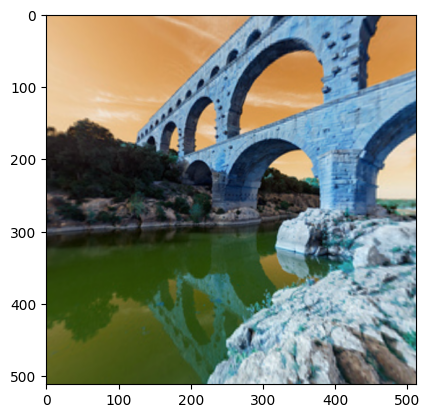

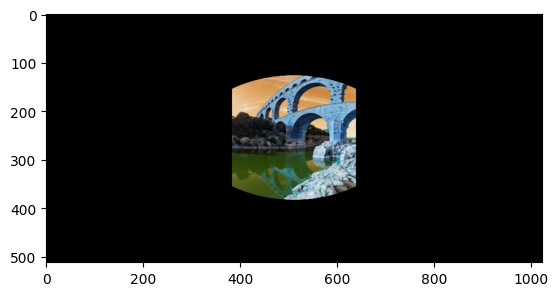

In [6]:
import matplotlib.pyplot as plt
plt.imshow(rectilinear_img)
plt.show()
plt.imshow(equirectangular_img)
plt.show()